# Load Library

In [43]:
# Load libraries
import pandas as pd
import numpy as np
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Load and Split data

In [44]:
# Load dataset
dataset = read_csv("D:/Academy/thesis/machin learning part/data/inputML_Q.csv")
# dataset = read_csv("D:/Academy/thesis/machin learning part/data/inputML_RGN.csv")
# dataset = read_csv("D:/Academy/thesis/machin learning part/data/random_inputML.csv")
#
dataset.set_index('name', inplace=True)
dataset['stage'].replace({'brain lower grade glioma':False, 'glioblastoma multiforme':True}, inplace=True)
dataset[dataset.select_dtypes(['object']).columns] = dataset.select_dtypes(['object']).apply(lambda x: x.astype('category'))
print(dataset.shape)

(702, 20)


In [24]:
# Split dataset
X = dataset.drop('stage', axis=1)
y = dataset['stage']
x_main, x_test, y_main, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_main, y_main, test_size=0.20, random_state=1, stratify=y_main)
# summarize
print('Train', x_train.shape, y_train.shape)
print('Test', x_test.shape, y_test.shape)
print('Validation', x_val.shape, y_val.shape)

Train (448, 19) (448,)
Test (141, 19) (141,)
Validation (113, 19) (113,)


NameError: name 'sort' is not defined

# Feature Selection

In [52]:
# require library
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

# define feature selection baced on ANOVA test
fs1 = SelectKBest(score_func=f_classif, k= 8)
fs2 = SelectKBest(score_func= mutual_info_classif, k=10)
fs1.fit(x_train, y_train)
fs2.fit(x_train, y_train)

# summarize selected features
print(x_train.columns.values[fs1.get_support()])
print(x_train.columns.values[fs2.get_support()])
x_train_fs1 = fs1.transform(x_train)
x_train_fs2 = fs2.transform(x_train)
print('Train_fs', x_train_fs1.shape)
print('Test_fs', x_train_fs2.shape)

['AREG' 'IGF1R' 'PLAT' 'BCAR1' 'HDAC3' 'PDGFA' 'PDGFB' 'UBA52']
['AREG' 'IGF1R' 'EGR1' 'PLAT' 'BCAR1' 'HDAC3' 'PDGFA' 'PDGFRA' 'PDGFB'
 'UBA52']
Train_fs (448, 8)
Test_fs (448, 10)


# Wrapper

In [55]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
rfe = RFE(estimator = model, n_features_to_select = 8)
rfe.fit(x_train, y_train)
x_train_rfe = rfe.transform(x_train)

# summarize selected features
print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Feature Ranking: %s" % rfe.ranking_)
x_train.columns.values[rfe.support_]

x_train_rfe = rfe.transform(x_train)
# summarize data
print('Train_fs', x_train_rfe.shape)

Num Features: 8
Selected Features: [False  True False  True False  True False  True False False False  True
 False  True  True False False  True False]
Feature Ranking: [10  1 12  1  2  1  6  1  9  3  8  1 11  1  1  4  7  1  5]


array(['EGFR', 'MYC', 'HSP90AA1', 'IGF1R', 'PLAT', 'HDAC3', 'PDGFA',
       'TGFA'], dtype=object)

Train_fs (448, 8)


In [36]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(2, 15):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = LinearSVC(dual=False, random_state=13)
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
	return scores

# define dataset
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, x_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
	print("Num Features: %d" % model.named_steps['s'])
	#print("Selected Features: %s" % model.support_)
	#print("Feature Ranking: %s" % model.ranking_)

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

>2 0.716 (0.092)


TypeError: %d format: a number is required, not RFE

In [4]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_test))
print(Counter(y_val))

Counter({False: 339, True: 109})
Counter({False: 106, True: 35})
Counter({False: 85, True: 28})


# Apply SMOTE

In [5]:
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)
print(Counter(y_train))

Counter({False: 339, True: 339})


In [5]:
print(Counter(y_train))

Counter({False: 339, True: 109})


# Fitting some Models

In [21]:
# Fitting Model
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from sklearn.feature_selection import RFE

# KNN
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors=12, metric='minkowski', p=2) 
knn.fit(x_train, y_train) 
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

# Decision Tree
from sklearn.tree import DecisionTreeClassifier 
dtc = DecisionTreeClassifier(criterion="gini", random_state=42, max_depth=3, min_samples_leaf=5) 
dtc = dtc.fit(x_train, y_train) 


# SVM
from sklearn.svm import SVC
svm = SVC(kernel = 'rbf')
svm = svm.fit(x_train, y_train) 

# Linear SVM
lsvm = LinearSVC(dual=False, random_state=13)
lsvm = lsvm.fit(x_train, y_train) 


# Logestic regression
LR = LogisticRegression(solver='liblinear')
LR = LR.fit(x_train, y_train)

#RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)
rfe = rfe.fit(x_train, y_train)     

# XGB
xgb = XGBClassifier(tree_method="hist")
xgb = xgb.fit(x_train, y_train) 

from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#Create an instance
# classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
#                                 sampling_strategy='not majority',
#                                 replacement=False,
#                                 random_state=42)

classifier = BalancedBaggingClassifier(random_state=42)
classifier.fit(x_train, y_train)


TypeError: __init__() takes 2 positional arguments but 3 were given

# Compare different Classifiers

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
models = []
models.append(('LR', LR))
models.append(('KNN', knn))
models.append(('DTC', dtc))
models.append(('SVM', svm))
models.append(('LSVM', lsvm))
models.append(('RFE',rfe))
models.append(('XGB', xgb))
models.append(('Bagging', classifier))


print(models)

# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring='f1')#f1 roc_auc
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


[('LR', LogisticRegression(solver='liblinear')), ('KNN', KNeighborsClassifier(n_neighbors=12)), ('DTC', DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)), ('SVM', SVC()), ('LSVM', LinearSVC(dual=False, random_state=13)), ('RFE', RFE(estimator=DecisionTreeClassifier(), n_features_to_select=15)), ('XGB', XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None

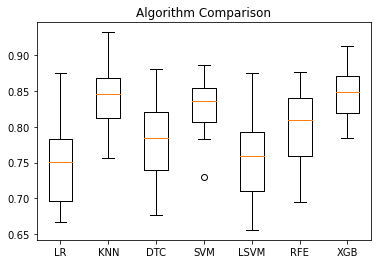

In [10]:
# Compare Algorithms
# import matplotlib. pyplot as plt 
# plt.boxplot(results, labels=names)
# plt.title('Algorithm Comparison')
# plt.show()

Best Threshold=0.240000, G-Mean=0.942


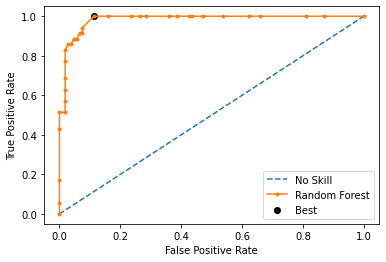

In [20]:
from sklearn.ensemble import RandomForestClassifier
from numpy import sqrt
from numpy import argmax
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot

rf_model = RandomForestClassifier()
rf_model.fit(x_train,y_train)   
y_hat = rf_model.predict_proba(x_test) #probability of the class label
y_hat = y_hat[:, 1]
y_hat
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, y_hat)
from numpy import sqrt
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Random Forest')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

# Model Evaluation on Test  set

In [10]:
# transform test input data
X_test_fs1 = fs1.transform(x_test)
X_test_rfe = rfe.transform(X_test)


Y_knn = knn.predict(x_test) 
Y_dtc = dtc.predict(x_test) 
Y_svm = svm.predict(x_test) 
Y_lr = LR.predict(x_test)
Y_lsvm = lsvm.predict(x_test) 
#Y_rfe = rfe.predict(x_test) 
Y_rfe = (rfe.predict_proba(x_test)[:,1] >= 0.2).astype(bool)
Y_xgb = xgb.predict(x_test) 

# Evaluate predictions 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy KNN: %.2f' % (f1_score(y_test, Y_knn)*100))
print('Accuracy DT: %.2f' % (f1_score(y_test, Y_dtc)*100))
print('Accuracy SVM: %.2f' % (f1_score(y_test, Y_svm)*100))
print('Accuracy LR: %.2f' % (f1_score(y_test, Y_lr)*100))
print('Accuracy LSVM: %.2f' % (f1_score(y_test, Y_lsvm)*100))
print('Accuracy RFE: %.2f' % (f1_score(y_test, Y_rfe)*100))
print('F1 Score XGB: %.2f' % (f1_score(y_test, Y_xgb)*100))
print(confusion_matrix(y_test, Y_rfe))
print(classification_report(y_test, Y_knn))
#accuracy_score
# roc_auc_score

Accuracy KNN: 86.84
Accuracy DT: 85.71
Accuracy SVM: 85.00
Accuracy LR: 85.71
Accuracy LSVM: 83.54
Accuracy RFE: 84.62
F1 Score XGB: 92.96
[[96 10]
 [ 2 33]]
              precision    recall  f1-score   support

       False       0.98      0.92      0.95       106
        True       0.80      0.94      0.87        35

    accuracy                           0.93       141
   macro avg       0.89      0.93      0.91       141
weighted avg       0.94      0.93      0.93       141



# Model Evaluation on Validation set

In [15]:
Y_knn_val = knn.predict(x_val) 
Y_dtc_val = dtc.predict(x_val) 
Y_svm_val = svm.predict(x_val) 
Y_lr_val = LR.predict(x_val) 
Y_lsvm_val = lsvm.predict(x_val) 
Y_rfe_val = rfe.predict(x_val)
#Y_rfe_val = (rfe.predict_proba(x_val)[:,1] >= 0.2).astype(bool)
Y_xgb_val = xgb.predict(x_val) 


# Evaluate predictions 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy KNN: %.2f' % (f1_score(y_val, Y_knn_val)*100))
print('Accuracy DT: %.2f' % (f1_score(y_val, Y_dtc_val)*100))
print('Accuracy SVM: %.2f' % (f1_score(y_val, Y_svm_val)*100))
print('Accuracy LR: %.2f' % (f1_score(y_val, Y_lr_val)*100))
print('Accuracy LSVM: %.2f' % (f1_score(y_val, Y_lsvm_val)*100))
print('Accuracy RFE: %.2f' % (f1_score(y_val, Y_rfe_val)*100))
print('F1 XGB: %.2f' % (f1_score(y_val, Y_xgb_val)*100))
print(confusion_matrix(y_val, Y_rfe_val))
#print(classification_report(y_test, Y_svm))

Accuracy KNN: 74.58
Accuracy DT: 74.07
Accuracy SVM: 77.97
Accuracy LR: 76.36
Accuracy LSVM: 78.57
Accuracy RFE: 63.16
F1 XGB: 79.25
[[74 11]
 [10 18]]
